In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [2]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 

import numpy as np
from sklearn import preprocessing, metrics, model_selection 
import pandas as pd

In [3]:
df = pd.read_csv(DATOS_DIR + 'Iris.csv')

# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
T = np.array(df.iloc[:,-1])

# Binarizador para convertir el nombre de la clase en one hot encoding
binarizer = preprocessing.LabelBinarizer()

# Binariza cada clase como una combinación de un 1 y 0s
T = binarizer.fit_transform(T)

print('Clases :', binarizer.classes_)


Clases : ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [4]:
#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, T_train, T_test = model_selection.train_test_split( \
        X, T, test_size=0.30) #, random_state=42)

#Y_trainB = to_categorical(Y_train)

In [5]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    # Escala los valores entre 0 y 1
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)

### Definición del modelo

In [6]:

# Crear un modelo de capas secuenciales
model=Sequential()

# Agregar las capas al modelo
model.add(Dense(20, input_shape=[4], activation='LeakyReLU'))
model.add(Dense(3, activation='softmax'))

# Imprimir un resumen del modelo
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.optimizers import SGD

model.compile(optimizer=SGD(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])



In [8]:
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping

# Define el callback
def on_epoch_end(epoch, logs):
    if (epoch + 1) % 20 == 0:  # Cambia 10 por el número de épocas deseado
        print(f"Epoch {epoch + 1}: loss = {logs['loss']}, accuracy = {logs['accuracy']}")

# Crea el LambdaCallback
epoch_end_callback = LambdaCallback(on_epoch_end=on_epoch_end)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=1e-08, restore_best_weights=True)

# Entrena el modelo con el callback
H = model.fit(X_train,T_train, epochs=1000, batch_size=40, validation_split=0.25, 
                    callbacks=[es, epoch_end_callback], verbose=0)

Epoch 20: loss = 0.4238636791706085, accuracy = 0.8461538553237915
Epoch 40: loss = 0.31639787554740906, accuracy = 0.8846153616905212
Epoch 60: loss = 0.26717573404312134, accuracy = 0.9230769276618958
Epoch 80: loss = 0.23404404520988464, accuracy = 0.9487179517745972


In [10]:
print("épocas = %d" % len(H.history["val_accuracy"]))   
print("Epocas = %d" % es.stopped_epoch)

épocas = 88
Epocas = 87


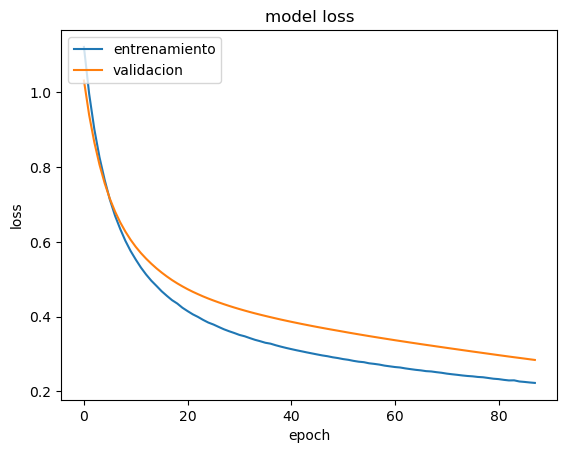

In [11]:
from matplotlib import pyplot as plt

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validacion'], loc='upper left')
plt.show()

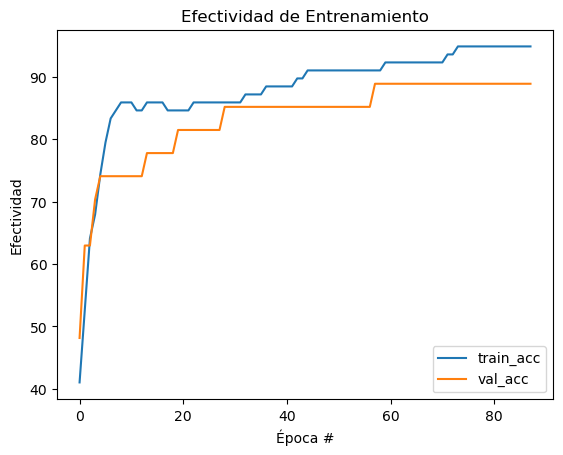

In [12]:
# dibuja accuracy del progreso del entrenamiento
accuracy = np.array(H.history["accuracy"])
val_accuracy = np.array(H.history["val_accuracy"])

N = np.arange(0, len(accuracy))
plt.figure()
plt.plot(N, 100*accuracy, label="train_acc")
plt.plot(N, 100*val_accuracy, label="val_acc")
plt.title("Efectividad de Entrenamiento")
plt.xlabel("Época #")
plt.ylabel("Efectividad")
plt.legend(loc="lower right")

In [13]:
# Evaluación del modelo
score = model.evaluate(X_train, T_train) 

print('Error :', score[0]) 
print('Accuracy:', score[1])


4/4 [==============================] - 0s 2ms/step - loss: 0.2886 - accuracy: 0.9048
Error : 0.288565456867218
Accuracy: 0.9047619104385376


In [14]:
# predecir la salida del modelo
Y = model.predict(X_train)

# "invierte" la transformacion binaria para obtener los nombres de las clases
T_str = binarizer.inverse_transform(T_train)
Y_str = binarizer.inverse_transform(Y)

print("%% aciertos : %.3f" % metrics.accuracy_score(T_str, Y_str))
print(Y[:5,:])
print(Y_str[:5])

4/4 [==============================] - 0s 1ms/step
% aciertos : 0.905
[[0.03871681 0.8753056  0.08597758]
 [0.96335083 0.02606177 0.01058734]
 [0.00696576 0.05028359 0.9427506 ]
 [0.00189128 0.04977374 0.948335  ]
 [0.00242797 0.09072203 0.9068499 ]]
['Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica']


In [15]:
report = metrics.classification_report(T_str, Y_str, target_names=binarizer.classes_)
print("Training metrics:\n%s" % report) 

MM = metrics.confusion_matrix(T_str, Y_str)
print("Confusion matrix:\n%s" % MM)

Training metrics:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        37
Iris-versicolor       0.88      0.82      0.85        34
 Iris-virginica       0.83      0.88      0.86        34

       accuracy                           0.90       105
      macro avg       0.90      0.90      0.90       105
   weighted avg       0.91      0.90      0.90       105

Confusion matrix:
[[37  0  0]
 [ 0 28  6]
 [ 0  4 30]]


In [16]:
# predecir la salida del modelo
Y_test = model.predict(X_test)

# "invierte" la transformacion binaria para obtener los nombres de las clases
T_test_str = binarizer.inverse_transform(T_test)
Y_test_str = binarizer.inverse_transform(Y_test)

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(T_test_str, Y_test_str))

2/2 [==============================] - 0s 1ms/step
% aciertos X_train : 0.867


In [17]:
report = metrics.classification_report(T_test_str, Y_test_str) #, target_names=etiquetas)

print("Métricas de la clasificación:\n%s" % report) 

Métricas de la clasificación:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.92      0.96        13
Iris-versicolor       0.86      0.75      0.80        16
 Iris-virginica       0.79      0.94      0.86        16

       accuracy                           0.87        45
      macro avg       0.88      0.87      0.87        45
   weighted avg       0.87      0.87      0.87        45



In [18]:
MM = metrics.confusion_matrix(T_test_str, Y_test_str)

print("Confusion matrix:\n%s" % MM)
# Convertimos la matriz de confusión en un DataFrame con etiquetas
etiquetas = binarizer.classes_
df_cm = pd.DataFrame(MM, index=etiquetas, columns=etiquetas)

# Mostramos el DataFrame resultante
print("\n\n",df_cm)

Confusion matrix:
[[12  1  0]
 [ 0 12  4]
 [ 0  1 15]]


                  Iris-setosa  Iris-versicolor  Iris-virginica
Iris-setosa               12                1               0
Iris-versicolor            0               12               4
Iris-virginica             0                1              15


In [19]:
capaOculta = model.layers[0]
W1, b1 = capaOculta.get_weights()

capaSalida = model.layers[1]
W2,b2 = capaSalida.get_weights()

print("W1")
print(W1)

print("b1")
print(b1)

print("W2")
print(W2)

print("b2")
print(b2)

W1
[[ 0.4809576  -0.10120706  0.23032483  0.13255005  0.02612378 -0.12597618
   0.46395823  0.16735713 -0.1555114   0.5187732   0.06368644 -0.08398585
  -0.31651565 -0.3607584  -0.060773    0.26488018 -0.20100921  0.30420828
   0.08726066 -0.01914542]
 [ 0.15196912 -0.5634764   0.23277606 -0.06661778  0.3014252   0.45012125
   0.00949307 -0.5277411  -0.19450697 -0.55008066  0.5896303   0.39047158
   0.03431311 -0.37553883 -0.4250903  -0.01756135  0.40396845  0.42529428
   0.02598406  0.17621972]
 [ 0.34577313 -0.42717132 -0.25119624 -0.54904824  0.3569175   0.34300455
   0.4289686   0.2624108   0.4554826   0.5198145  -0.3542577   0.38216615
  -0.11216474  0.21232359 -0.00498735  0.4553105  -0.0707829  -0.21561891
  -0.11763739 -0.07795792]
 [-0.24172054  0.4415435   0.3360589  -0.27377278  0.07188898  0.12223652
   0.20461453 -0.54876095 -0.10791858  0.062804   -0.76075834  0.6261162
  -0.23442139 -0.27960116  0.6045024   0.4715176  -0.00777573 -0.01042669
  -0.17920585 -0.34187293]]
b

In [20]:
#model.save("IRIS_Sigmoid.h5")